# Train Convolutional Neural Network

#### This notebook takes chipped .tif SAR images and their corresponding labeled masks, and trains a convolutional neural network (CNN) to attempt to label wildfire regions in new images.

### Setup 

In [1]:
import json
import numpy as np
import rasterio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, ImageDraw
import os
import itertools
from sklearn.metrics import accuracy_score

### Data Loading and Dataset Creation

In [2]:
# SETUP

# function to load tif
def load_tif_image(tif_path):
    with rasterio.open(tif_path) as src:
        image = src.read().astype(np.float32)
        image = np.moveaxis(image, 0, -1)  
    return image

# function to load tif mask
def load_tif_mask(mask_path):
    with rasterio.open(mask_path) as src:
        mask = src.read(1).astype(np.uint8)  
    return mask

# function to concatenate image/mask pairs from multiple directories
def concat_dirs(image_dirs, mask_dirs):
    image_files = []
    mask_files = []
    for img_dir, mask_dir in zip(image_dirs, mask_dirs):
        images = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(".tif")])
        masks = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".tif")])
        image_files.extend(images)
        mask_files.extend(masks)
    return image_files, mask_files

# format image and mask for torch
class TIFDataset(Dataset):
    def __init__(self, image_paths, mask_paths):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = load_tif_image(self.image_paths[idx])
        mask = load_tif_mask(self.mask_paths[idx])
        image = torch.tensor(image).permute(2, 0, 1) 
        mask = torch.tensor(mask).unsqueeze(0).float() 
        return image, mask

In [3]:
# load data!

# enter dirs and call above function
image_dirs = [r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C10_SM_GEO_HH_20250114013943_20250114013952\tiles_tif",
              r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C10_SS_GEO_HH_20250113021051_20250113021104\tiles_tif",
              r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C11_SP_GEO_HH_20250112202415_20250112202441\tiles_tif",
              r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C13_SM_GEO_HH_20250115210818_20250115210823\tiles_tif",
              r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C13_SM_GEO_HH_20250116125106_20250116125111\tiles_tif",
              r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C13_SM_GEO_HH_20250118200502_20250118200506\tiles_tif",
              r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C13_SM_GEO_HH_20250119114748_20250119114753\tiles_tif",
              r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C13_SM_GEO_HH_20250119183651_20250119183655\tiles_tif",
              r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C14_SS_GEO_HH_20250111145546_20250111145602\tiles_tif",
              r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C14_SS_GEO_HH_20250111163649_20250111163705\tiles_tif",
              r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C14_SS_GEO_HH_20250112081445_20250112081501\tiles_tif",
              r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C15_SS_GEO_HH_20250111190504_20250111190518\tiles_tif",
              r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C15_SS_GEO_HH_20250112191305_20250112191319\tiles_tif"]

mask_dirs = [r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C10_SM_GEO_HH_20250114013943_20250114013952\tiles_masks",
             r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C10_SS_GEO_HH_20250113021051_20250113021104\tiles_masks",
             r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C11_SP_GEO_HH_20250112202415_20250112202441\tiles_masks",
             r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C13_SM_GEO_HH_20250115210818_20250115210823\tiles_masks",
             r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C13_SM_GEO_HH_20250116125106_20250116125111\tiles_masks",
             r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C13_SM_GEO_HH_20250118200502_20250118200506\tiles_masks",
             r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C13_SM_GEO_HH_20250119114748_20250119114753\tiles_masks",
             r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C13_SM_GEO_HH_20250119183651_20250119183655\tiles_masks",
             r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C14_SS_GEO_HH_20250111145546_20250111145602\tiles_masks",
             r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C14_SS_GEO_HH_20250111163649_20250111163705\tiles_masks",
             r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C14_SS_GEO_HH_20250112081445_20250112081501\tiles_masks",
             r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C15_SS_GEO_HH_20250111190504_20250111190518\tiles_masks",
             r"C:\Users\Owner\FIREMAPS\Data\Wildfires\CAPELLA_C15_SS_GEO_HH_20250112191305_20250112191319\tiles_masks"]

image_files, mask_files = concat_dirs(image_dirs, mask_dirs)

# load and create train/test sets
dataset = TIFDataset(image_files, mask_files)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2)

### CNN Model Design and Hyperparameter Initialization

In [4]:
# initialize CNN
class CNNModel(nn.Module):
    def __init__(self, in_channels=1, num_filters=[32, 64, 128]):  
        super(CNNModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, num_filters[0], kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(num_filters[0], num_filters[1], kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(num_filters[1], num_filters[2], kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(num_filters[2], num_filters[1], kernel_size=3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(num_filters[1], num_filters[0], kernel_size=3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(num_filters[0], 1, kernel_size=3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
# Define hyperparameter grid
param_grid = {
    "learning_rate": [0.001, 0.0005, 0.0001], 
    "batch_size": [2, 4],  
    "num_filters": [[32, 64, 128], [64, 128, 256]] 
}
hyperparameter_combinations = list(itertools.product(*param_grid.values()))

### CNN Training with Hyperparameter Grid Search

In [8]:
# Build and train model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu if available

# initialize model tracker
best_model = None
best_accuracy = 0 
results = []

# train using hyperparam grid search
for params in hyperparameter_combinations:
    lr, batch_size, num_filters = params
    print(f"Training with: LR={lr}, Batch Size={batch_size}, Filters={num_filters}")

    # load
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize Model
    model = CNNModel(in_channels=1, num_filters=num_filters).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # train!
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}")

    # apply to test set
    model.eval()
    total_correct = 0
    total_pixels = 0
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            predicted = (outputs > 0.5).float() 
            total_correct += (predicted == masks).sum().item()
            total_pixels += masks.numel()
    accuracy = total_correct / total_pixels
    print(f"Validation Accuracy: {(accuracy * 100):.2f}%")  

    # update best model if this one is better than stored model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

    results.append({
        "learning_rate": lr,
        "batch_size": batch_size,
        "num_filters": num_filters,
        "test_accuracy": accuracy
    })

# results
print("\nHyperparameter Grid Search Results:")
for res in results:
    print(res)

torch.save(best_model.state_dict(), "best_cnn_model.pth")
print("\nBest Model Saved.")

Training with: LR=0.001, Batch Size=2, Filters=[32, 64, 128]
Epoch 1/20, Loss: 1059.9171
Epoch 2/20, Loss: 967.8652
Epoch 3/20, Loss: 968.3333
Epoch 4/20, Loss: 969.9805
Epoch 5/20, Loss: 1003.3783
Epoch 6/20, Loss: 960.0858
Epoch 7/20, Loss: 968.0748
Epoch 8/20, Loss: 970.2073
Epoch 9/20, Loss: 968.9196
Epoch 10/20, Loss: 968.7067
Epoch 11/20, Loss: 975.8226
Epoch 12/20, Loss: 974.9350
Epoch 13/20, Loss: 969.0752
Epoch 14/20, Loss: 970.7292
Epoch 15/20, Loss: 950.1492
Epoch 16/20, Loss: 946.3063
Epoch 17/20, Loss: 958.7780
Epoch 18/20, Loss: 944.4378
Epoch 19/20, Loss: 942.5601
Epoch 20/20, Loss: 940.0291
Validation Accuracy: 75.25%
Training with: LR=0.001, Batch Size=2, Filters=[64, 128, 256]
Epoch 1/20, Loss: 1487.2092
Epoch 2/20, Loss: 984.0551
Epoch 3/20, Loss: 968.8500
Epoch 4/20, Loss: 969.2892
Epoch 5/20, Loss: 971.2870
Epoch 6/20, Loss: 968.7975
Epoch 7/20, Loss: 966.2007
Epoch 8/20, Loss: 969.4781
Epoch 9/20, Loss: 969.1418
Epoch 10/20, Loss: 988.8366
Epoch 11/20, Loss: 966.9

In [12]:
# enter hyperparams for the best model output above ^^^
best_hyperparams = {
    "learning_rate": 0.0001,  
    "batch_size": 2, 
    "num_filters": [64, 128, 256] 
}

# save model, including hyperparams this time
torch.save({"model_state_dict": best_model.state_dict(), "hyperparams": best_hyperparams}, "best_cnn_model.pth")

### Inspect Model 

In [13]:
# inspect model architecture
checkpoint = torch.load("best_cnn_model.pth", map_location=device)
best_hyperparams = checkpoint["hyperparams"]

model = CNNModel(in_channels=1, num_filters=best_hyperparams["num_filters"]).to(device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

CNNModel(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

### Testing!

I'll save multiple copies of the same plotting code block below with some nice outputs from my run.

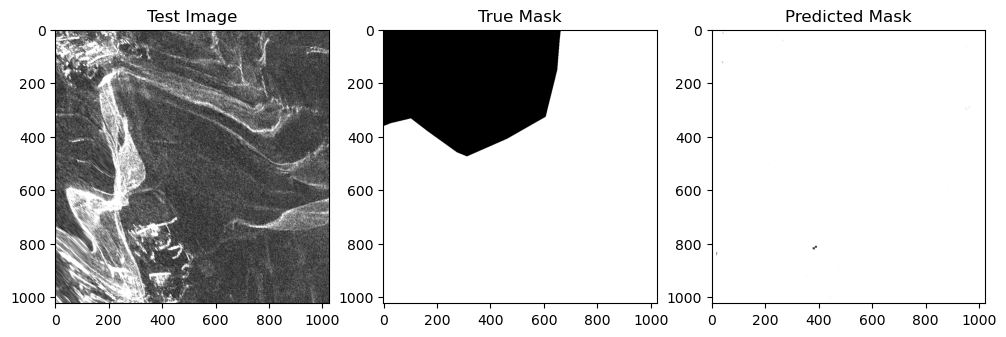

In [507]:
# load model
checkpoint = torch.load("best_cnn_model.pth", map_location=device)
best_hyperparams = checkpoint["hyperparams"]  # Load hyperparameters

# choose test image to plot
test_image, test_mask = test_dataset[124] # <<< CHOOSE IMAGE HERE
test_image = test_image.unsqueeze(0).to(device)  

# predict based on best model
with torch.no_grad():
    predicted_mask = model(test_image)
predicted_mask = (predicted_mask > 0.5).float().squeeze().cpu().numpy()
test_image = test_image.squeeze().cpu().numpy()
test_mask = test_mask.squeeze().cpu().numpy()

# plot image, true mask, pred mask
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(test_image.squeeze(), cmap="gray") 
ax[0].set_title("Test Image")
ax[1].imshow(test_mask, cmap="gray")
ax[1].set_title("True Mask")
ax[2].imshow(predicted_mask, cmap="gray")
ax[2].set_title("Predicted Mask")
plt.show()

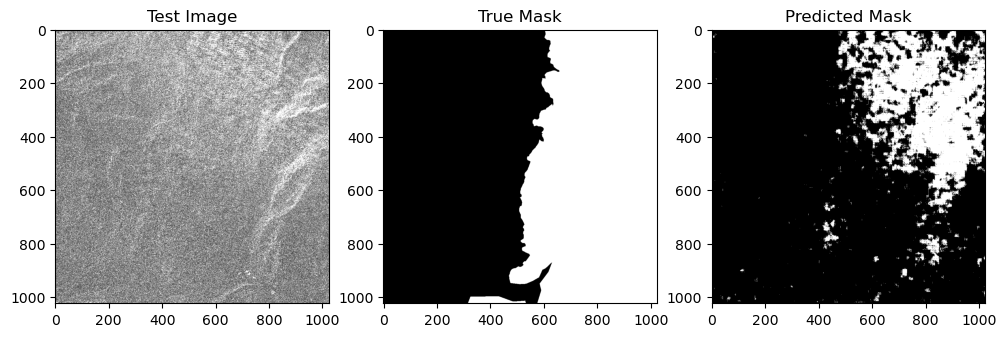

In [508]:
# load model
checkpoint = torch.load("best_cnn_model.pth", map_location=device)
best_hyperparams = checkpoint["hyperparams"]  # Load hyperparameters

# choose test image to plot
test_image, test_mask = test_dataset[159] # <<< CHOOSE IMAGE HERE
test_image = test_image.unsqueeze(0).to(device)  

# predict based on best model
with torch.no_grad():
    predicted_mask = model(test_image)
predicted_mask = (predicted_mask > 0.5).float().squeeze().cpu().numpy()
test_image = test_image.squeeze().cpu().numpy()
test_mask = test_mask.squeeze().cpu().numpy()

# plot image, true mask, pred mask
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(test_image.squeeze(), cmap="gray") 
ax[0].set_title("Test Image")
ax[1].imshow(test_mask, cmap="gray")
ax[1].set_title("True Mask")
ax[2].imshow(predicted_mask, cmap="gray")
ax[2].set_title("Predicted Mask")
plt.show()

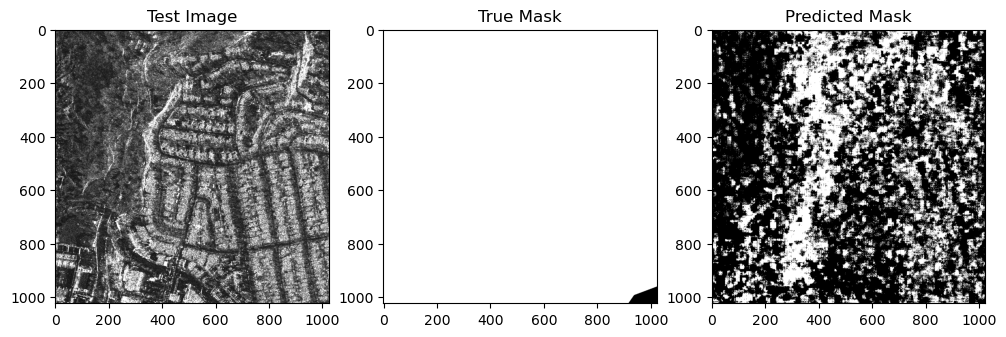

In [509]:
# load model
checkpoint = torch.load("best_cnn_model.pth", map_location=device)
best_hyperparams = checkpoint["hyperparams"]  # Load hyperparameters

# choose test image to plot
test_image, test_mask = test_dataset[197] # <<< CHOOSE IMAGE HERE
test_image = test_image.unsqueeze(0).to(device)  

# predict based on best model
with torch.no_grad():
    predicted_mask = model(test_image)
predicted_mask = (predicted_mask > 0.5).float().squeeze().cpu().numpy()
test_image = test_image.squeeze().cpu().numpy()
test_mask = test_mask.squeeze().cpu().numpy()

# plot image, true mask, pred mask
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(test_image.squeeze(), cmap="gray") 
ax[0].set_title("Test Image")
ax[1].imshow(test_mask, cmap="gray")
ax[1].set_title("True Mask")
ax[2].imshow(predicted_mask, cmap="gray")
ax[2].set_title("Predicted Mask")
plt.show()

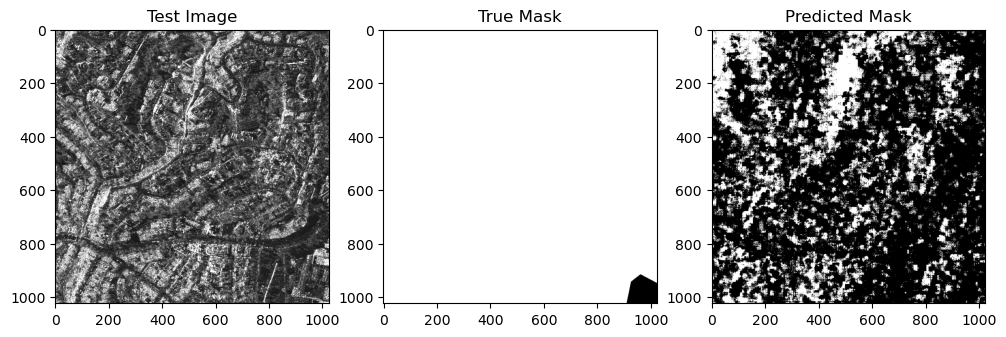

In [510]:
# load model
checkpoint = torch.load("best_cnn_model.pth", map_location=device)
best_hyperparams = checkpoint["hyperparams"]  # Load hyperparameters

# choose test image to plot
test_image, test_mask = test_dataset[203] # <<< CHOOSE IMAGE HERE
test_image = test_image.unsqueeze(0).to(device)  

# predict based on best model
with torch.no_grad():
    predicted_mask = model(test_image)
predicted_mask = (predicted_mask > 0.5).float().squeeze().cpu().numpy()
test_image = test_image.squeeze().cpu().numpy()
test_mask = test_mask.squeeze().cpu().numpy()

# plot image, true mask, pred mask
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(test_image.squeeze(), cmap="gray") 
ax[0].set_title("Test Image")
ax[1].imshow(test_mask, cmap="gray")
ax[1].set_title("True Mask")
ax[2].imshow(predicted_mask, cmap="gray")
ax[2].set_title("Predicted Mask")
plt.show()

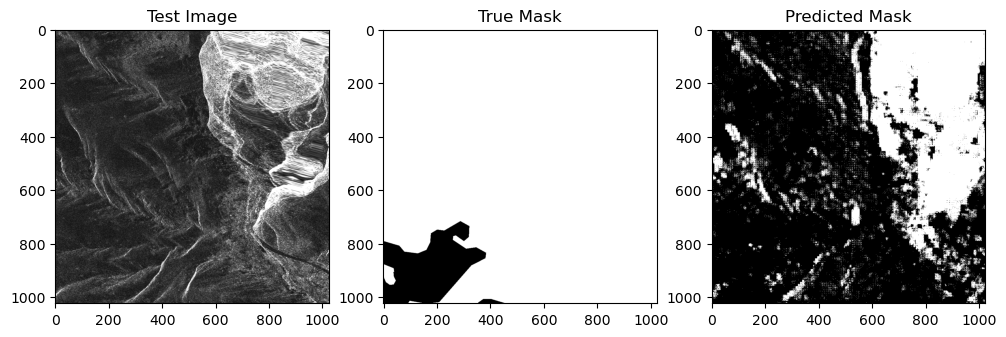

In [511]:
# load model
checkpoint = torch.load("best_cnn_model.pth", map_location=device)
best_hyperparams = checkpoint["hyperparams"]  # Load hyperparameters

# choose test image to plot
test_image, test_mask = test_dataset[324] # <<< CHOOSE IMAGE HERE
test_image = test_image.unsqueeze(0).to(device)  

# predict based on best model
with torch.no_grad():
    predicted_mask = model(test_image)
predicted_mask = (predicted_mask > 0.5).float().squeeze().cpu().numpy()
test_image = test_image.squeeze().cpu().numpy()
test_mask = test_mask.squeeze().cpu().numpy()

# plot image, true mask, pred mask
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(test_image.squeeze(), cmap="gray") 
ax[0].set_title("Test Image")
ax[1].imshow(test_mask, cmap="gray")
ax[1].set_title("True Mask")
ax[2].imshow(predicted_mask, cmap="gray")
ax[2].set_title("Predicted Mask")
plt.show()

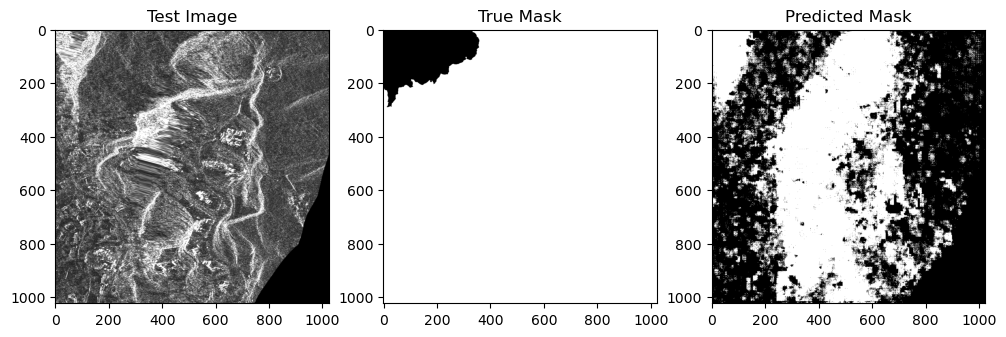

In [512]:
# load model
checkpoint = torch.load("best_cnn_model.pth", map_location=device)
best_hyperparams = checkpoint["hyperparams"]  # Load hyperparameters

# choose test image to plot
test_image, test_mask = test_dataset[377] # <<< CHOOSE IMAGE HERE
test_image = test_image.unsqueeze(0).to(device)  

# predict based on best model
with torch.no_grad():
    predicted_mask = model(test_image)
predicted_mask = (predicted_mask > 0.5).float().squeeze().cpu().numpy()
test_image = test_image.squeeze().cpu().numpy()
test_mask = test_mask.squeeze().cpu().numpy()

# plot image, true mask, pred mask
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(test_image.squeeze(), cmap="gray") 
ax[0].set_title("Test Image")
ax[1].imshow(test_mask, cmap="gray")
ax[1].set_title("True Mask")
ax[2].imshow(predicted_mask, cmap="gray")
ax[2].set_title("Predicted Mask")
plt.show()

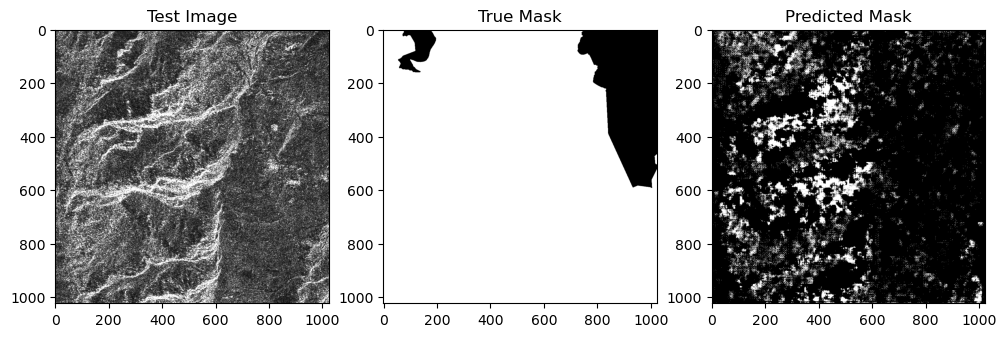

In [513]:
# load model
checkpoint = torch.load("best_cnn_model.pth", map_location=device)
best_hyperparams = checkpoint["hyperparams"]  # Load hyperparameters

# choose test image to plot
test_image, test_mask = test_dataset[498] # <<< CHOOSE IMAGE HERE
test_image = test_image.unsqueeze(0).to(device)  

# predict based on best model
with torch.no_grad():
    predicted_mask = model(test_image)
predicted_mask = (predicted_mask > 0.5).float().squeeze().cpu().numpy()
test_image = test_image.squeeze().cpu().numpy()
test_mask = test_mask.squeeze().cpu().numpy()

# plot image, true mask, pred mask
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(test_image.squeeze(), cmap="gray") 
ax[0].set_title("Test Image")
ax[1].imshow(test_mask, cmap="gray")
ax[1].set_title("True Mask")
ax[2].imshow(predicted_mask, cmap="gray")
ax[2].set_title("Predicted Mask")
plt.show()